In [1]:
%cd /content/drive/MyDrive/
# raw_data is imported from global config

/content/drive/MyDrive


In [2]:
%%capture
! pip install mne==0.19.2;
! pip install torch==1.7.0;

In [3]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from grasp.TSception.utils import regulization
from grasp.utils import SEEGDataset, load_data, SEEGDataset3D, cuda_or_cup, set_random_seeds
from grasp.TSception.Models import TSception2,wholenet
from grasp.braindecode.Models import shallowConv,deepConv
from grasp.process.channel_settings import badtrials
from grasp.config import root_dir

In [4]:
import sys, importlib
importlib.reload(sys.modules['grasp.TSception.Models'])
from grasp.TSception.Models import TSception2,wholenet,SelectionLayer

In [5]:
import inspect as i
import sys
#sys.stdout.write(i.getsource(SelectionLayer))

In [6]:
device=cuda_or_cup()
enable_cuda = torch.cuda.is_available()
print('GPU computing: ', enable_cuda)
seed = 123456789  # random seed to make results reproducible
# Set random seed to be able to reproduce results
set_random_seeds(seed=seed)

GPU computing:   True
GPU computing:  True


In [7]:
sid=10 # 10 converge faster
optins=['normalized_frequency_and_raw','frequency_and_raw','raw']
input=optins[2]

#result_dir=root_dir+'grasp/TSception/shallowConv'+str(sid)+'/'
result_dir=root_dir+'grasp/TSception/result_TSSmall'+'_'+input+str(sid)+'/'
saved_numpy=result_dir+'result/'
pths=result_dir+'pth/'
pro_dir=result_dir + '/probs/'

import os
if not os.path.exists(result_dir):
    os.makedirs(result_dir)
if not os.path.exists(saved_numpy):
    os.makedirs(saved_numpy)
if not os.path.exists(pths):
    os.makedirs(pths)
if not os.path.exists(pro_dir):
    os.makedirs(pro_dir)

In [8]:
%%capture
# suppress the output
traindata, valdata, testdata = load_data(sid,split=True,move2=True,input=input)
traindata = traindata.transpose(2, 0, 1)  #-->(trials94,channels,  time)
valdata = valdata.transpose(2, 0, 1) # 32
testdata = testdata.transpose(2, 0, 1)  # 8

In [9]:
# Total trial number from train, val and test dataset should be equal to total trial from config file.
total_trials1=traindata.shape[0]+valdata.shape[0]+testdata.shape[0]
total_trials2=4*40-(len(badtrials[sid][0])+len(badtrials[sid][1])+len(badtrials[sid][2])+len(badtrials[sid][3]))
if total_trials1!=total_trials2:
    raise SystemExit("Trial number dones't match")
trainx, trainy = traindata[:, :-2, :], traindata[:, -2, :] #-2 is real force, -1 is target
valx, valy = valdata[:, :-2, :], valdata[:, -2, :]
testx, testy = testdata[:, :-2, :], testdata[:, -2, :]

In [10]:
if input=='normalized_frequency_and_raw':
    fs=250
    step=125
    T=250
else:
    fs=1000
    step=500 #ms
    T=1000 #ms
dataset_train = SEEGDataset3D(trainx, trainy,T,step)
dataset_val = SEEGDataset3D(valx, valy,T,step)
dataset_test = SEEGDataset3D(testx, testy,T,step)
train_loader = DataLoader(dataset=dataset_train, batch_size=1, shuffle=True, pin_memory=False)
val_loader = DataLoader(dataset=dataset_val, batch_size=1, pin_memory=False)
test_loader = DataLoader(dataset=dataset_test, batch_size=1, pin_memory=False)

In [11]:
epochs=800

# TSception parameter
sampling_rate=1000
learning_rate=0.002
totalLen=trainx.shape[2] #ms
batch_size=int((totalLen-T)/step) # 280
num_T = 3 # (6 conv2d layers) * ( 3 kernel each layer)
num_S = 3
hidden_size=222
dropout=0.5
#Lambda = 1e-10

# braindecode parameter
checkshape=torch.squeeze(next(iter(test_loader))[0],dim=0) # torch.Size([28,1,102,1000])
length=checkshape.shape[3] # torch.Size([28, 102, 1000])
convfeature=40
tkernelSize=200
avgpoolKernel=100
maxpoolKernel=3
maxpoolStride=3
blockKernelSize=10
input_dim=checkshape.shape[2]

# selection neuron
M=10

In [12]:
#Create schedule for temperature and regularization threshold
#Create a vector of length epochs, decaying start_value to end_value exponentially, reaching end_value at end_epoch

start_temp=20
end_temp=0.1
start_thresh=8.0
end_thresh=1.1

def exponential_decay_schedule(start_value,end_value,epochs,end_epoch):
    t = torch.FloatTensor(torch.arange(0.0,epochs))
    p = torch.clamp(t/end_epoch,0,1)
    out = start_value*torch.pow(end_value/start_value,p)
    return out

temperature_schedule = exponential_decay_schedule(start_temp,end_temp,epochs,int(epochs*3/4)) #one-hot degree
thresh_schedule = exponential_decay_schedule(start_thresh,end_thresh,epochs,epochs) # duplication penalty


In [13]:
#Network loss function
def loss_function(output,target,model,lamba,weight_decay):
    l = nn.MSELoss()
    sup_loss = l(output,target)
    reg = model.regularizer(lamba,weight_decay)
    return sup_loss,reg

weight_decay=1e-6 #1e-6 # model parameter weight decay
lamba=0.1 # 0.1 regularization of penalization of duplication selection

enable_select=True
# def __init__(self, input_dim, M ,sampling_rate, chnNum, num_T, num_S,dropout):
#Question: forward called during initialization throw error: RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!
#Git log: 36b198f7a49df375b8562f5d2d8c2bbef5dbbc61
#Solution1: find a PC with GPU to debug.
#Solution2: no need to call selection layer forward. Dimmension is determinant for selection layer.
shape=checkshape.shape # torch.Size([28,1,102,1000])
if enable_select==True:
    net = wholenet(shape,enable_select,input_dim, M, sampling_rate,M, num_T, num_S,dropout)
    net.enable_select = True
    net.set_freeze(False)
else:
    net = wholenet(shape,enable_select,input_dim, M, sampling_rate, input_dim, num_T, num_S, dropout)
    net.enable_select = False


if(enable_cuda):
    net.cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adagrad(net.parameters(), lr=learning_rate,weight_decay=1e-4)


In [14]:
torch.cuda.is_available()

True

In [15]:
#checkpoint = torch.load(result_dir+'checkpoint440.pth')
#net.load_state_dict(checkpoint['net'])
#optimizer.load_state_dict(checkpoint['optimizer'])

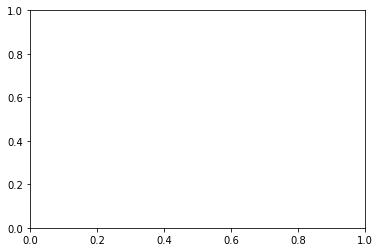

In [16]:
fig2, ax2=plt.subplots()

In [ ]:
debugg = False
#debugg=True
for epoch in range(epochs):
    print("------ epoch " + str(epoch) + " -----")
    net.train()
    if enable_select==True:
        net.set_thresh(thresh_schedule[epoch])
        net.set_temperature(temperature_schedule[epoch])

    loss_epoch = 0
    # trial=0
    for trial, (trainx, trainy) in enumerate(train_loader):  # ([1, 15000, 19]), ([1, 15000])
        if debugg == True:  # just test one trial
            if trial == 1:
                break
                pass
        optimizer.zero_grad()

        if (enable_cuda):
            x = trainx.float().cuda()
            target = trainy.float().cuda()
        else:
            x = trainx.float()
            target = trainy.float()
        y_pred = net(x)
        # target = torch.from_numpy(target)

        sup_loss, reg = loss_function(y_pred, target.float(), net,lamba, weight_decay)
        loss = sup_loss + reg  # regulization
        loss_epoch+=sup_loss.item()

        loss.backward()
        optimizer.step()

    print("" + str(epoch) + " loss:" + str(loss_epoch / (trial + 1)) + ".")
    if epoch % 2 == 0:
        if net.enable_select==True:
            H, sel, probas = net.monitor()
            ax2.imshow(probas.cpu().detach().numpy(),origin='lower',cmap='RdBu_r',aspect='auto')
            im=ax2.images[-1]
            fig2.colorbar(im)
            fig2.savefig(pro_dir + 'prob_dist' + str(epoch) + '.png')
            im.colorbar.remove()
            ax2.clear()

        net.eval()
        print("Validating...")
        with torch.no_grad():
            vpredAll = []
            vtargetAll = []
            for trial, (vx, vtarget) in enumerate(val_loader):  # ([1, 15000, 19]), ([1, 15000])
                if (enable_cuda):
                    vx = vx.float().cuda()
                    vtarget = vtarget.float().cuda()
                else:
                    vx = vx.float()
                    vtarget = vtarget.float()
                y_pred = net(vx)
                

                y_pred = y_pred.squeeze().cpu().detach().numpy()
                vtarget = vtarget.squeeze().cpu().numpy()
                vpredAll.append(y_pred)
                vtargetAll.append(vtarget)

        vpredAll = np.concatenate(vpredAll, axis=0)
        vtargetAll = np.concatenate(vtargetAll, axis=0)
        #loss_val = criterion(torch.from_numpy(vpredAll.squeeze()), torch.from_numpy(vtargetAll.squeeze()))

        pred_target=np.concatenate((vpredAll[:,None],vtargetAll[:,None]),axis=1)
        save_pred=saved_numpy + 'prediction_epoch' + str(epoch) + '.npy'
        np.save(save_pred, pred_target)

        fig, ax = plt.subplots(figsize=(6, 3))
        plt.ion()
        ax.clear()
        ax.plot(vtargetAll, label="True", linewidth=1)
        ax.plot(vpredAll, label='Predicted - Test', linewidth=1)
        ax.legend(loc='upper left')
        figname = result_dir + 'prediction' + str(epoch) + '.png'
        fig.savefig(figname)
        plt.close(fig)
    if epoch % 10 == 0:
        state = {
            'net': net.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        savepath = pths + 'checkpoint' + str(epoch) + '.pth'
        torch.save(state, savepath)

------ epoch 0 -----
0 loss:0.3020581212372352.
Validating...
------ epoch 1 -----
1 loss:0.2140293407261881.
------ epoch 2 -----
